# Segmentation of linestrings

The objective of this notebook is to compile a data set consisting of segmented voltage cables **(reducing nodes while remaining the original graph structure)** per region as a supporting solution for lvc reconstructor problem.

In [2]:
import geopandas as gpd
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from pathlib import Path
import os

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_81354/3283919339.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [5]:
ROOT = Path(os.getcwd()).parent.parent
DATA_ATOM = os.path.join(ROOT, 'data', 'atom')

In [6]:
CRS = 4326

laagspanningskabel = gpd.read_parquet(Path(DATA_ATOM, 'laagspanningskabels_x_station.pyarrow'))
laagspanningskabel = laagspanningskabel.to_crs(pyproj.CRS.from_epsg(CRS))
laagspanningskabel.head()

,id,geometry,station,kv
0,3337146,"LINESTRING (5.70785 51.95208, 5.70783 51.95208...",OS RENKUM,< 0.4
1,3337161,"LINESTRING (5.70684 51.95345, 5.70683 51.95343...",OS RENKUM,< 0.4
2,3337172,"LINESTRING (5.70719 51.95240, 5.70719 51.95240...",OS RENKUM,< 0.4
3,3337187,"LINESTRING (5.70743 51.95292, 5.70740 51.95293...",OS RENKUM,< 0.4
4,3337202,"LINESTRING (5.70761 51.95377, 5.70760 51.95377...",OS RENKUM,< 0.4


## Sample OS RENKUM

In [7]:
gpd_os_renkum = laagspanningskabel[laagspanningskabel.station == 'OS RENKUM'].copy()
gpd_os_renkum.head()

,id,geometry,station,kv
0,3337146,"LINESTRING (5.70785 51.95208, 5.70783 51.95208...",OS RENKUM,< 0.4
1,3337161,"LINESTRING (5.70684 51.95345, 5.70683 51.95343...",OS RENKUM,< 0.4
2,3337172,"LINESTRING (5.70719 51.95240, 5.70719 51.95240...",OS RENKUM,< 0.4
3,3337187,"LINESTRING (5.70743 51.95292, 5.70740 51.95293...",OS RENKUM,< 0.4
4,3337202,"LINESTRING (5.70761 51.95377, 5.70760 51.95377...",OS RENKUM,< 0.4


<Axes: >

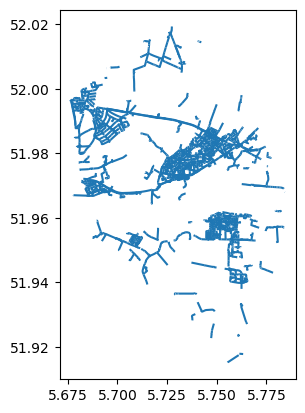

In [8]:
gpd_os_renkum.plot()

## Segmentation Algorithm

In [9]:
def geo_network_segmenter(gpd_os_renkum: gpd.GeoDataFrame):
    os_rokum = gpd_os_renkum.copy()
    segmentation_network = {}
    ref_id = 0

    seed = os_rokum.iloc[-1]
    os_rokum = os_rokum[:-1]
    sub_network = gpd.GeoDataFrame([seed], columns=gpd_os_renkum.columns, crs=pyproj.CRS.from_epsg(CRS)).set_geometry('geometry')

    while len(os_rokum) > 0:
        union = unary_union(sub_network.geometry)
        geometrical_distance = union.distance(os_rokum.geometry)
        neighbors = os_rokum[geometrical_distance == 0]

        if neighbors.size == 0:
            segmentation_network[ref_id] = sub_network
            seed = os_rokum.iloc[-1]
            os_rokum = os_rokum[:-1]
            sub_network = gpd.GeoDataFrame([seed], columns=gpd_os_renkum.columns, crs=pyproj.CRS.from_epsg(CRS)).set_geometry('geometry')
            ref_id += 1
        else:
            sub_network = pd.concat([sub_network, neighbors], ignore_index=True).drop_duplicates(subset=['id'])
            neighbors_idx = list(neighbors.index)
            only_non_visited_idx = ~os_rokum.index.isin(neighbors_idx)
            os_rokum = os_rokum.iloc[only_non_visited_idx]

    return segmentation_network

In [10]:
%%time

import warnings
warnings.filterwarnings('ignore')

segmentation_network = geo_network_segmenter(gpd_os_renkum)

CPU times: user 50 s, sys: 221 ms, total: 50.2 s
Wall time: 50.3 s


In [11]:
print(f'Num. of segments that exist: {len(segmentation_network)}')

Num. of segments that exist: 298


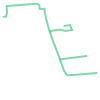

In [36]:
sample_merged = unary_union(segmentation_network[0].geometry)
sample_merged

Merge all to form segments

In [37]:
all_segments_merged = [unary_union(seg.geometry) for seg in segmentation_network.values()]

In [38]:
geo_segments = gpd.GeoDataFrame({
    'geometry': all_segments_merged,
    'ref_id': segmentation_network.keys()
})

geo_segments.head()

,geometry,ref_id
0,"MULTILINESTRING ((5.73003 51.97524, 5.73003 51...",0
1,"MULTILINESTRING ((5.71611 51.94823, 5.71606 51...",1
2,"MULTILINESTRING ((5.70492 51.99644, 5.70492 51...",2
3,"MULTILINESTRING ((5.74879 51.95390, 5.74879 51...",3
4,"MULTILINESTRING ((5.74755 51.98706, 5.74757 51...",4


In [83]:
number_of_vertices_origin = 0

for idx in range(len(segmentation_network)):
    number_of_vertices_origin += segmentation_network[idx].geometry.apply(lambda x: len(x.coords)).sum()

number_of_vertices_origin

59933

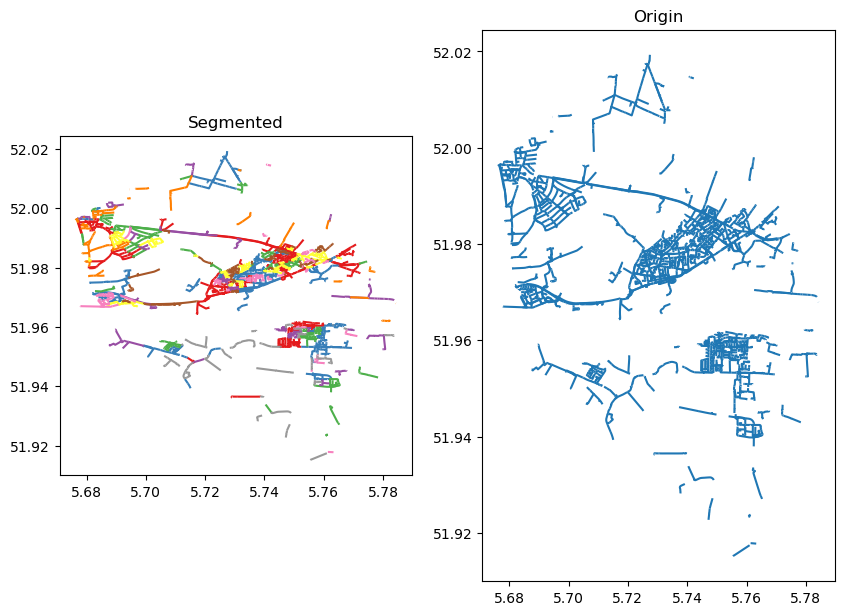

In [89]:
size = 10

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(size, size))
ax[0].set_title('Segmented')
ax[1].set_title('Origin')
geo_segments.plot(ax=ax[0], cmap='Set1')
gpd_os_renkum.plot(ax=ax[1]);

In [ ]:
# geo_segments.explore(column="ref_id", cmap="Set1", tooltip="ref_id").save('segment.html')